In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
from timeit import default_timer as timer
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.patches as mpatches
import lightgbm as lgb
import scipy
from sklearn import datasets, linear_model, metrics 

In [2]:
cd C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\Anomaly Detection

C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\Anomaly Detection


In [36]:
colnames = ["VDS_ID","Lane Count","Loop Count"]
for i in range(1,11):
    colnames.append('Loop_{}_FLOW'.format(i))
    colnames.append('Loop_{}_Occupancy'.format(i))
    colnames.append('Loop_{}_status'.format(i))

health_data_day2 = pd.read_csv('Good_Data_30thSept.csv',sep = ',')
health_data_US101N_day2 = health_data_day2.loc[health_data_day2['Fwy'] == 'US101-N']
health_data_US101N_day2 = health_data_US101N_day2.drop_duplicates(subset=['VDS'],keep = 'last')
health_data_US101N_day2 = health_data_US101N_day2.reset_index(drop = True)
li_test = []
li_groups = []
li_complete_groups = []
data_test = pd.DataFrame()
def pre_processing_test(day):
    global li_test
    global li_groups
    global li_complete_groups
    global data_test  
    path = r'C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\\' + day + '\\'
    
    all_files = glob.glob(path + "/*.txt")
    for filename in all_files:
        if  int(filename[-10:-8]) >= 5 and int(filename[-10:-8]) <=21:        
            df = pd.read_csv(filename,index_col = None, delimiter = ",",names = colnames ,skiprows = 1)
            df= df.drop(['Lane Count','Loop Count','Loop_1_status','Loop_8_status','Loop_2_status','Loop_3_status',
                         'Loop_4_status','Loop_5_status','Loop_6_status','Loop_7_status','Loop_8_status','Loop_9_status',
                         'Loop_10_status'],axis = 1)
            df['time'] = datetime.strptime(str(int(filename[-18:-4])),'%Y%m%d%H%M%S')
            li_test.append(df)
            
    li_test = [df.loc[df['VDS_ID'].isin(health_data_US101N_day2.VDS.values)] for df in li_test]
    temp_df = pd.concat(li_test)
    tg = temp_df.groupby('VDS_ID')
    
    for name, group in tg:
        group = group[[each for each in group.columns if 'Occupancy' not in each]]
        li_groups.append(group)
        
    for dataframe in li_groups:
        dataframe = dataframe[[column for column in dataframe.columns if 'Occuapncy' not in column]]
        dataframe = dataframe.dropna(axis = 1,how = 'all')
        dataframe = dataframe.reset_index(drop = True)
        cols = dataframe.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        dataframe = dataframe[cols]
        dataframe = dataframe.T
        new_header = dataframe.iloc[0]
        dataframe = dataframe[1:]
        dataframe.columns = new_header   
        dataframe.index = dataframe.index + '_' + str(dataframe.iloc[0].values[0])
        dataframe = dataframe[1:]
        li_complete_groups.append(dataframe)
    
    data_test = pd.concat(li_complete_groups)
    data_test = data_test.fillna(0)
    
    for col in data_test.columns:
        data_test[col] = data_test[col].astype(float)
        
    x = data_test.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    data_test_scaled = pd.DataFrame()
    data_test_scaled = pd.DataFrame(x_scaled)

     ### Calculate the euclidean distances
    mat = scipy.spatial.distance.cdist(data_test_scaled,data_test_scaled, metric='euclidean')
    distances_df = pd.DataFrame()
    distances_df = pd.DataFrame(mat, index=data_test.index, columns=data_test.index)
    arr = np.argsort(-distances_df.values, axis=1)
    df1 = pd.DataFrame(distances_df.columns[arr], index=distances_df.index)
    a = distances_df.values
    a.sort(axis=1)
    a = a[:,::-1]
    sorted_distances_df = pd.DataFrame()
    sorted_distances_df = pd.DataFrame(a,distances_df.index,distances_df.columns)

  
    for i,j in zip(range(1,6),range(2,7)):
        data_test["Neighbor{0}".format(i)] = df1.iloc[:,-j]
        data_test["distance{0}".format(i)] = sorted_distances_df.iloc[:,-j]

    return data_test

pre_processing_test('20190930')
data_test.head()

time                2019-09-30 05:00:00  2019-09-30 05:00:30  \
Loop_1_FLOW_716337                 16.0                  7.0   
Loop_2_FLOW_716337                 11.0                  9.0   
Loop_3_FLOW_716337                  7.0                  7.0   
Loop_4_FLOW_716337                  9.0                  7.0   
Loop_1_FLOW_716359                  2.0                  4.0   

time                2019-09-30 05:01:00  2019-09-30 05:01:30  \
Loop_1_FLOW_716337                  3.0                 16.0   
Loop_2_FLOW_716337                  5.0                 10.0   
Loop_3_FLOW_716337                  7.0                 10.0   
Loop_4_FLOW_716337                  5.0                 11.0   
Loop_1_FLOW_716359                  2.0                  2.0   

time                2019-09-30 05:02:00  2019-09-30 05:02:30  \
Loop_1_FLOW_716337                  7.0                 11.0   
Loop_2_FLOW_716337                  9.0                  7.0   
Loop_3_FLOW_716337                  7.0                 11.0   
Loop_4_FLOW_716337                  2.0                 10.0   
Loop_1_FLOW_716359                  5.0                  1.0   

time                2019-09-30 05:03:00  2019-09-30 05:03:30  \
Loop_1_FLOW_716337                  7.0                  3.0   
Loop_2_FLOW_716337                 12.0                  8.0   
Loop_3_FLOW_716337                  6.0                  7.0   
Loop_4_FLOW_716337                 11.0                  4.0   
Loop_1_FLOW_716359                  4.0                  2.0   

time                2019-09-30 05:04:00  2019-09-30 05:04:30  ...  \
Loop_1_FLOW_716337                  8.0                  9.0  ...   
Loop_2_FLOW_716337                 12.0                  8.0  ...   
Loop_3_FLOW_716337                  6.0                 10.0  ...   
Loop_4_FLOW_716337                  6.0                  8.0  ...   
Loop_1_FLOW_716359                  1.0                  2.0  ...   

time                         Neighbor1  distance1           Neighbor2  \
Loop_1_FLOW_716337  Loop_1_FLOW_765164   4.876041  Loop_2_FLOW_716337   
Loop_2_FLOW_716337  Loop_3_FLOW_765164   5.565329  Loop_1_FLOW_716337   
Loop_3_FLOW_716337  Loop_4_FLOW_765164   6.013084  Loop_4_FLOW_716337   
Loop_4_FLOW_716337  Loop_3_FLOW_716337   6.675619  Loop_2_FLOW_716337   
Loop_1_FLOW_716359  Loop_2_FLOW_716359   6.998509  Loop_2_FLOW_717491   

time                distance2           Neighbor3  distance3  \
Loop_1_FLOW_716337   6.466033  Loop_3_FLOW_765164   6.723554   
Loop_2_FLOW_716337   6.466033  Loop_3_FLOW_716337   6.692992   
Loop_3_FLOW_716337   6.675619  Loop_2_FLOW_716337   6.692992   
Loop_4_FLOW_716337   7.146814  Loop_4_FLOW_765164   7.584190   
Loop_1_FLOW_716359   7.710781  Loop_4_FLOW_716359   7.787800   

time                         Neighbor4  distance4           Neighbor5  \
Loop_1_FLOW_716337  Loop_3_FLOW_716337   7.347334  Loop_4_FLOW_716337   
Loop_2_FLOW_716337  Loop_1_FLOW_765164   6.908330  Loop_4_FLOW_765164   
Loop_3_FLOW_716337  Loop_3_FLOW_765164   7.058172  Loop_1_FLOW_716337   
Loop_4_FLOW_716337  Loop_1_FLOW_716337   7.744095  Loop_3_FLOW_765164   
Loop_1_FLOW_716359  Loop_3_FLOW_716359   8.323443  Loop_1_FLOW_717491   

time                distance5  
Loop_1_FLOW_716337   7.744095  
Loop_2_FLOW_716337   7.127814  
Loop_3_FLOW_716337   7.347334  
Loop_4_FLOW_716337   7.774266  
Loop_1_FLOW_716359   8.398501  

[5 rows x 2050 columns]

In [37]:
health_data = pd.read_csv('Good_Data_23rdSept.csv',sep = ',')
health_data_US101N = health_data.loc[health_data['Fwy'] == 'US101-N']
health_data_US101N = health_data_US101N.drop_duplicates(subset=['VDS'],keep = 'last')
health_data_US101N = health_data_US101N.reset_index(drop = True)
li_train = []
li_groups = []
li_complete_groups = []
data_train = pd.DataFrame()
def pre_processing_train(day):
    global li_train
    global li_groups
    global li_complete_groups
    global data_train    
    path = r'C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\\' + day + '\\'
    all_files = glob.glob(path + "/*.txt")
    
    for filename in all_files:
        if  int(filename[-10:-8]) >= 5 and int(filename[-10:-8]) <=21:    
            df = pd.read_csv(filename,index_col = None, delimiter = ",",names = colnames ,skiprows = 1)
            df= df.drop(['Lane Count','Loop Count','Loop_1_status','Loop_8_status','Loop_2_status','Loop_3_status',
                         'Loop_4_status','Loop_5_status','Loop_6_status','Loop_7_status','Loop_8_status','Loop_9_status',
                         'Loop_10_status'],axis = 1)
            df['time'] = datetime.strptime(str(int(filename[-18:-4])),'%Y%m%d%H%M%S')
            df = df.reset_index(drop = True)
            li_train.append(df)
            
    li_train = [df.loc[df['VDS_ID'].isin(health_data_US101N.VDS.values)] for df in li_train]
    temp_df = pd.concat(li_train)
    tg = temp_df.groupby('VDS_ID')
    
    for name, group in tg:
        group = group[[each for each in group.columns if 'Occupancy' not in each]]
        li_groups.append(group)
        
    for dataframe in li_groups:
        dataframe = dataframe[[column for column in dataframe.columns if 'Occuapncy' not in column]]
        dataframe = dataframe.dropna(axis = 1,how = 'all')
        dataframe = dataframe.reset_index(drop = True)
        cols = dataframe.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        dataframe = dataframe[cols]
        dataframe = dataframe.T
        new_header = dataframe.iloc[0]
        dataframe = dataframe[1:]
        dataframe.columns = new_header   
        dataframe.index = dataframe.index + '_' + str(dataframe.iloc[0].values[0])
        dataframe = dataframe[1:]
        li_complete_groups.append(dataframe)
    
    data_train = pd.concat(li_complete_groups)
    data_train = data_train[data_train.index.isin(data_test.index)]
    data_train = data_train.fillna(0)
    
    for col in data_train.columns:
        data_train[col] = data_train[col].astype(float)      
    
    x = data_train.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    data_train_scaled = pd.DataFrame(x_scaled)
    mat = scipy.spatial.distance.cdist(data_train_scaled,data_train_scaled, metric='euclidean')
    distances_df = pd.DataFrame(mat, index=data_train.index, columns=data_train.index)
    arr = np.argsort(-distances_df.values, axis=1)
    df1 = pd.DataFrame(distances_df.columns[arr], index=distances_df.index)
    a = distances_df.values
    a.sort(axis=1)
    a = a[:,::-1]
    sorted_distances_df = pd.DataFrame(a,distances_df.index,distances_df.columns)
    for i,j in zip(range(1,6),range(2,7)):
        data_train["Neighbor{0}".format(i)] = df1.iloc[:,-j]
        data_train["distance{0}".format(i)] = sorted_distances_df.iloc[:,-j]
    return data_train

pre_processing_train('20190923')
data_train.head()

time                2019-09-23 05:00:00  2019-09-23 05:00:30  \
Loop_1_FLOW_716337                  7.0                  8.0   
Loop_2_FLOW_716337                 10.0                  5.0   
Loop_3_FLOW_716337                  7.0                 10.0   
Loop_4_FLOW_716337                  7.0                  6.0   
Loop_1_FLOW_716359                  3.0                  1.0   

time                2019-09-23 05:01:00  2019-09-23 05:01:30  \
Loop_1_FLOW_716337                  7.0                  8.0   
Loop_2_FLOW_716337                 11.0                  7.0   
Loop_3_FLOW_716337                  6.0                  7.0   
Loop_4_FLOW_716337                  8.0                  3.0   
Loop_1_FLOW_716359                  2.0                  1.0   

time                2019-09-23 05:02:00  2019-09-23 05:02:30  \
Loop_1_FLOW_716337                 16.0                 16.0   
Loop_2_FLOW_716337                 13.0                 15.0   
Loop_3_FLOW_716337                 11.0                  9.0   
Loop_4_FLOW_716337                 14.0                  7.0   
Loop_1_FLOW_716359                  1.0                  4.0   

time                2019-09-23 05:03:00  2019-09-23 05:03:30  \
Loop_1_FLOW_716337                 10.0                 11.0   
Loop_2_FLOW_716337                  8.0                 11.0   
Loop_3_FLOW_716337                  9.0                  7.0   
Loop_4_FLOW_716337                  5.0                  9.0   
Loop_1_FLOW_716359                  3.0                  3.0   

time                2019-09-23 05:04:00  2019-09-23 05:04:30  ...  \
Loop_1_FLOW_716337                  5.0                  9.0  ...   
Loop_2_FLOW_716337                 10.0                  7.0  ...   
Loop_3_FLOW_716337                  6.0                  8.0  ...   
Loop_4_FLOW_716337                 11.0                 10.0  ...   
Loop_1_FLOW_716359                  1.0                  1.0  ...   

time                         Neighbor1  distance1           Neighbor2  \
Loop_1_FLOW_716337  Loop_1_FLOW_765164   4.711941  Loop_2_FLOW_716337   
Loop_2_FLOW_716337  Loop_3_FLOW_765164   5.146710  Loop_1_FLOW_716337   
Loop_3_FLOW_716337  Loop_4_FLOW_765164   5.803279  Loop_2_FLOW_716337   
Loop_4_FLOW_716337  Loop_3_FLOW_716337   6.956421  Loop_2_FLOW_716337   
Loop_1_FLOW_716359  Loop_2_FLOW_717491   7.041052  Loop_2_FLOW_716359   

time                distance2           Neighbor3  distance3  \
Loop_1_FLOW_716337   6.230205  Loop_3_FLOW_765164   6.379053   
Loop_2_FLOW_716337   6.230205  Loop_1_FLOW_765164   6.624517   
Loop_3_FLOW_716337   6.735067  Loop_4_FLOW_716337   6.956421   
Loop_4_FLOW_716337   7.338036  Loop_4_FLOW_765164   7.634710   
Loop_1_FLOW_716359   7.111355  Loop_4_FLOW_716359   7.769032   

time                         Neighbor4  distance4           Neighbor5  \
Loop_1_FLOW_716337  Loop_3_FLOW_716337   7.385191  Loop_4_FLOW_765164   
Loop_2_FLOW_716337  Loop_3_FLOW_716337   6.735067  Loop_4_FLOW_765164   
Loop_3_FLOW_716337  Loop_3_FLOW_765164   7.025870  Loop_1_FLOW_716337   
Loop_4_FLOW_716337  Loop_3_FLOW_765164   7.955558  Loop_1_FLOW_716337   
Loop_1_FLOW_716359  Loop_3_FLOW_716359   8.095938  Loop_1_FLOW_717491   

time                distance5  
Loop_1_FLOW_716337   7.778902  
Loop_2_FLOW_716337   7.030195  
Loop_3_FLOW_716337   7.385191  
Loop_4_FLOW_716337   8.055705  
Loop_1_FLOW_716359   8.175624  

[5 rows x 2026 columns]

In [38]:
RMSE_LGBM_US101N = []
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmsle',
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0, 
}    
start = timer()
for i in data_train.index:
    N1 = data_train.loc[[data_train.loc[[i]].values[:1,2016:2017][0][0]]].iloc[:,0:2016]
    N2 = data_train.loc[[data_train.loc[[i]].values[:1,2018:2019][0][0]]].iloc[:,0:2016]
    N3 = data_train.loc[[data_train.loc[[i]].values[:1,2020:2021][0][0]]].iloc[:,0:2016]
    N4 = data_train.loc[[data_train.loc[[i]].values[:1,2022:2023][0][0]]].iloc[:,0:2016]
    N5 = data_train.loc[[data_train.loc[[i]].values[:1,2024:2025][0][0]]].iloc[:,0:2016]   
    train_list = [N1,N2,N3,N4,N5]
    training_data_model = pd.concat(train_list).T
    training_data_model[i] = data_train.loc[[i]].values[:1,0:2016][0]
    X_train = training_data_model.drop([i],axis=1)
    y_train = training_data_model[[i]].astype(float)
    d_train = lgb.Dataset(X_train, label=y_train)
    clf = lgb.train(params, d_train, 100)
    K1 = data_test.loc[[N1.index[0]]].iloc[:,0:2040]
    K2 = data_test.loc[[N2.index[0]]].iloc[:,0:2040]
    K3 = data_test.loc[[N3.index[0]]].iloc[:,0:2040]
    K4 = data_test.loc[[N4.index[0]]].iloc[:,0:2040]
    K5 = data_test.loc[[N5.index[0]]].iloc[:,0:2040]   
    test_list = [K1,K2,K3,K4,K5]
    testing_data_model = pd.concat(test_list).T
    testing_data_model[i] = data_test.loc[[i]].values[:1,0:2040][0]
    X_test = testing_data_model.drop([i],axis=1)
    y_test = testing_data_model[[i]]
    y_pred=clf.predict(X_test)
    df1 = pd.DataFrame()
    df1 = y_test.copy()
    df1['Predicted_LGBM'] = y_pred
    error = np.sqrt(np.mean((df1.Predicted_LGBM-df1[i])**2))
    RMSE_LGBM_US101N.append(error)
    del df1
end = timer()
from statistics import mean,median
RMSE_LGBM_US101N = [x for x in RMSE_LGBM_US101N if x != 0]
print(f'Time Required to impute data for all loops on I605S using LGBM and 5 nearest neighbors {end-start} seconds')
print(f'no of models : {len(RMSE_LGBM_US101N)}')
print(f'avg_RMSE :{mean(RMSE_LGBM_US101N)}')
print(f'median_RMSE :{median(RMSE_LGBM_US101N)}')
print(f'max_RMSE : {max(RMSE_LGBM_US101N)}')
print(f'min_RMSE : {min(RMSE_LGBM_US101N)}')

Time Required to impute data for all loops on I605S using LGBM and 5 nearest neighbors 46.09228447999976 seconds
no of models : 318
avg_RMSE :2.543874181708434
median_RMSE :2.4834139210322093
max_RMSE : 4.976658619466706
min_RMSE : 1.2757877765127337


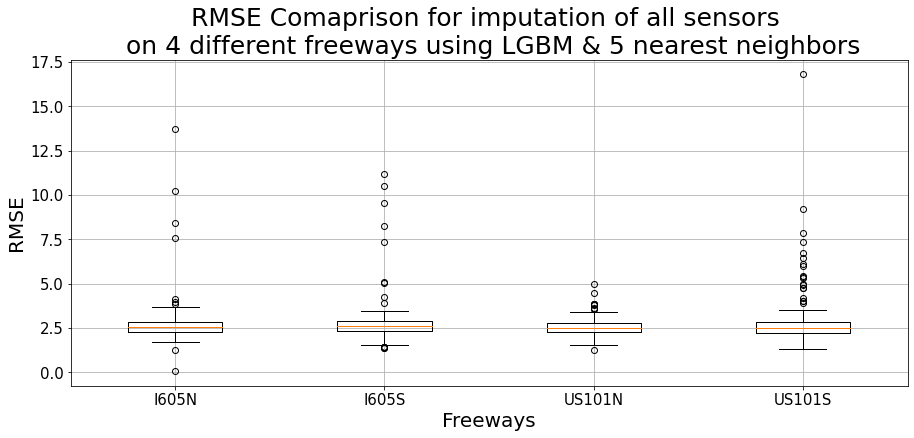

In [45]:
data_to_plot = [RMSE_LGBM_I605N,RMSE_LGBM_I605S,RMSE_LGBM_US101N,RMSE_LGBM_US101S]
# Create a figure instance
fig = plt.figure(1, figsize=(15, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_to_plot)
ax.tick_params(axis='both',labelsize=15)
plt.xticks([1, 2, 3,4], ['I605N', 'I605S', 'US101N','US101S'])
plt.title('RMSE Comaprison for imputation of all sensors \n on 4 different freeways using LGBM & 5 nearest neighbors',fontsize= 25)
plt.ylabel('RMSE',fontsize = 20)
plt.xlabel('Freeways',fontsize = 20)
plt.grid()
plt.savefig('Regression_Boxplots_All_Freeways_LGBM.png')